## Setting up to Work

The first part of the process, importing the libraries and depend

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

Loading dataset, after downloading it from kaggle: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset.

In [3]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

## Exploratory Data Analysis

The first steps are to understand the data, in order to do so, first we may get some general information about the dataset through the `head()`, `info()` and `describe()`.

In [4]:
df[(df['gender'] == 'Male') & (df['age'] == 23.0) & (df['diabetes'] == 1)]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
42197,Male,23.0,0,0,No Info,27.32,5.7,145,1
57911,Male,23.0,0,0,No Info,27.59,7.0,159,1
76268,Male,23.0,0,0,never,22.46,6.5,140,1
79982,Male,23.0,0,0,No Info,40.33,8.2,220,1
82655,Male,23.0,0,0,never,31.41,6.2,140,1


In [5]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


So, after a brief analysis we may conclude:
- There are a plentiful number of data available, 100.000 cases.
- The data doesn't contain any explicit error-leading missing values such as NAs, but it has the `No info` class of `smoking_history`.
- There are two categorical variables, `gender` and `smoking_history`, both will have to be transformed to a numerical value.
- `diabetes`, the target, is a boolean value and have a mean of 0.085. Meaning that only 8.5% of the cases in fact have diabetes implying on a imbalanced dataset.

Next, we going to analyse the `smoking_history` feature as it appears to be problematic for being a categorical feature with missing values. 

The first step is to check the possible values this feature can take and their respective frequencies. As shown in the next cell, this feature has a couple of issues:
- `No Info` appears in 35916 cases, meaning that more than one-third of the cases has a unespecified value on this feature (missing data).
- There are ambiguous and overlapping categories. For example, `not current` could mean the same as `former` or `never`, and the criteria that distinguise `ever` from `current` is poorly defined.

Considering the high number of unkown values and the ambiguity in class definition, a further evaluations is needed to assess this feature impact on the target prediction. This will help justify the efford of keeping this feature, or determine if it should be discarded.

In [8]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In order to further evaluate, we'll define a `ColumnTransformer` and transform the categorical values through the One-Hot Encoding. With the categorical data transformed, we can then use some feature metrics, such as Mutual Information score and correlation, to understand the features relevance to the target.

In [9]:
# Separetes the Features from the Target.
X = df.drop(['diabetes'], axis=1)
y = df['diabetes']

CT = ColumnTransformer(
    transformers = [ 
        ('onehot', OneHotEncoder(sparse_output=False, categories='auto'), ['gender', 'smoking_history']), #sparse_output=False
        #('ordinal', OrdinalEncoder(categories=[['never','No Info', 'not current', 'former', 'current', 'ever']]), ['smoking_history']) #sparse_output=False
    ],	
    remainder='passthrough'
)

In [10]:
# Applies the OneHot onto categorical features.
X_encoded = CT.fit_transform(X[['gender', 'smoking_history']])
encoded_cols = CT.get_feature_names_out(['gender', 'smoking_history'])

X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)
X_features = pd.concat([X.drop(['gender', 'smoking_history'], axis=1), X_encoded_df], axis=1)

### Correlation
Analyzing the correlation between the features and the target variable, allows us to see which of the features are most strong linear related to the target.

In [11]:
df_trans = pd.concat([X_features, y], axis=1)
df_trans.corr()['diabetes'].sort_values(ascending=False)


diabetes                               1.000000
blood_glucose_level                    0.419558
HbA1c_level                            0.400660
age                                    0.258008
bmi                                    0.214357
hypertension                           0.197823
heart_disease                          0.171727
onehot__smoking_history_former         0.097917
onehot__gender_Male                    0.037666
onehot__smoking_history_never          0.027267
onehot__smoking_history_ever           0.024080
onehot__smoking_history_not current    0.020734
onehot__smoking_history_current        0.019606
onehot__gender_Other                  -0.004090
onehot__gender_Female                 -0.037553
onehot__smoking_history_No Info       -0.118939
Name: diabetes, dtype: float64

### Mutual Information
Mutual Information can capture many types of relationships that each variable may have with the target, not being limited by linear associations only.

In [12]:
# Calcula a MI
mi_scores = mutual_info_classif(X_features, y)

# Exibe os resultados
mi_df = pd.DataFrame({'Feature': X_features.columns, 'MI Score': mi_scores})
print(mi_df.sort_values(by='MI Score', ascending=False))


                                Feature  MI Score
4                           HbA1c_level  0.130815
5                   blood_glucose_level  0.113673
0                                   age  0.039631
3                                   bmi  0.025169
6                 onehot__gender_Female  0.017122
9       onehot__smoking_history_No Info  0.015365
1                          hypertension  0.013750
2                         heart_disease  0.010467
7                   onehot__gender_Male  0.009577
13        onehot__smoking_history_never  0.006879
12       onehot__smoking_history_former  0.005621
11         onehot__smoking_history_ever  0.001153
8                  onehot__gender_Other  0.000000
10      onehot__smoking_history_current  0.000000
14  onehot__smoking_history_not current  0.000000


### PCA
Using PCA we may obtain valueble information about components made using the linear combination of the available data.

In [13]:
X_filtered = X_features[["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]]
X_scaled = (X_filtered - X_filtered.mean(axis=0)) / X_filtered.std(axis=0)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

comp_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=comp_names)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=comp_names,
    index=X_filtered.columns,  
)
print(loadings)

                          PC1       PC2       PC3       PC4       PC5
age                  0.566264 -0.265468 -0.057950 -0.156845 -0.023003
hypertension         0.421370 -0.175895  0.029841  0.864849  0.076444
heart_disease        0.352297 -0.143349  0.818735 -0.296400 -0.018912
bmi                  0.456550 -0.218234 -0.569784 -0.360819 -0.056236
HbA1c_level          0.284349  0.656053  0.000659  0.058274 -0.696617
blood_glucose_level  0.297298  0.632461 -0.027746 -0.077440  0.710515


In [14]:
mi_scores = mutual_info_classif(X_pca, y)
mi_df = pd.DataFrame({'Feature': X_pca.columns, 'MI Score': mi_scores})
print(mi_df)

  Feature  MI Score
0     PC1  0.111983
1     PC2  0.073283
2     PC3  0.043330
3     PC4  0.052579
4     PC5  0.037846


## Feature Selection and Preprocessing
Now, it's time to select the features that we'll use on our prediction. As we saw that the smoking history isn't a particularly good feature to invest in this case, we'll exclude it from the selected features. After that, we'll split our dataset to use 75% of it to training and the other 25% to test our prediction model.

In [15]:
# Separetes the Features from the Target.
X = df.drop(['diabetes', 'smoking_history'], axis=1)
y = df['diabetes']

CT = ColumnTransformer(
    transformers = [ 
        ('onehot', OneHotEncoder(sparse_output=False, categories='auto'), ['gender']), #sparse_output=False
    ],	
    remainder='passthrough'
)

# Applies the OneHot onto categorical features.
X_encoded = CT.fit_transform(X[['gender']])
encoded_cols = CT.get_feature_names_out(['gender'])

X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)
X_features = pd.concat([X.drop(['gender'], axis=1), X_encoded_df], axis=1)


As we saw earlier on the EDA, the dataset we're using is imbalanced. The target `diabetes` has the value of 0 much more frequently than 1, with 91.5% of the cases being 0 and 8.5% being 1. In order to ensure that the data will be splitted in a way that keeps the original distribution, we will set it to stratify the split based on the target values.

In [16]:
# Splits 75 for training and 25 for test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, stratify=y, test_size=0.25)

## Modeling
Here we're going to train a Gradient Boosting with 400 decision trees, fitting it to the train data.

In [17]:
model_gboost_baseline = GradientBoostingClassifier(n_estimators = 400, random_state=0).fit(X_train, y_train)

It is very important to evaluate the classification report wisely. Precision isn't the only thing that cares, even more on this case as we've got a imbalanced dataset. So the recall and f1-score tells us that the model may be predicting a higher number of false negatives than it appears by only looking to the precision score.

In [18]:
y_pred = model_gboost_baseline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22875
           1       0.96      0.69      0.80      2125

    accuracy                           0.97     25000
   macro avg       0.97      0.84      0.89     25000
weighted avg       0.97      0.97      0.97     25000

[[22820    55]
 [  657  1468]]


In fact, our model gets right 68% of the diabetics people diagnosed. We may trade a bit of false negatives with false positives by changing the confidence that our model has to have to consider a prediction of diabetes as true, using 0.3 of probability as a threshold to predict `True` instead of 0.5.

#### Adjusting Confidence Threshold


Binary classification is based upon probability. Basically, the model's output represents its confidence that the input belongs to the positive class, in other words, the output is the probability that the model "believes" the patient is diabetic. By default, if the model's output exceeds 0.5, the input is labeled as class 1, if the value is lower than 0.5, then the input is classified as class 0. Meaning that, by default, the confidence threshold is 0.5.

However, the threshold can be adjusted, leading the model to be more or less likely to label an input as belonging towards a class or another. This can be particularly useful in cases such as this one, where we do have an imbalanced dataset that causes our model to have a higher confidence on predicting the negative classe than the positive, as it got way more 0 class examples during its training. 

Since we know now that, in this case, the threshold should be lower than 0.5, we still have an infinite number of values to choose between 0 and 0.5. So, to help sorting out which numbers could be good candidates, we will plot the ROC-AUC curve, which shows the relationship beetween the threshold values to `True Positive Rate` and `False Positive Rate`. 


First, we get the probabilities from the model and use the metric `roc_curve` from scikit-learn to compute the true and false positives rates (also the thresholds samples). The we plot those values.

In [19]:
y_prob = model_gboost_baseline.predict_proba(X_test)[:, 1]  # Probabilidade da classe 1 (diabéticos)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

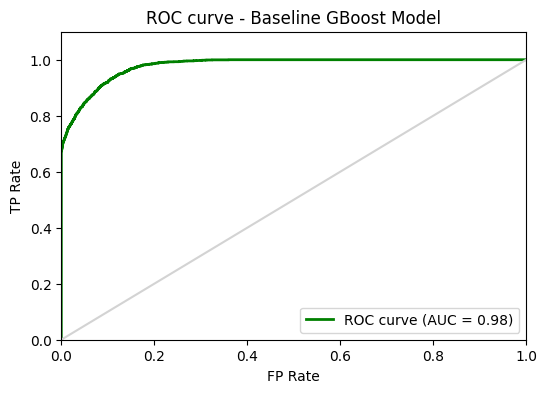

In [20]:
plt.figure(figsize=(6, 4))
plt.title('ROC curve - Baseline GBoost Model')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgray')
plt.axis([0.0, 1.0, 0.0, 1.1])
plt.legend(loc='lower right')
plt.show()

The ROC curve shows that a good value would be around 0.3, so we may test some options as: `0.3`, `0.25` and `0.2`.

In [21]:
y_proba = model_gboost_baseline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22875
           1       0.86      0.74      0.79      2125

    accuracy                           0.97     25000
   macro avg       0.92      0.86      0.89     25000
weighted avg       0.97      0.97      0.97     25000

[[22610   265]
 [  557  1568]]


In [22]:
y_proba = model_gboost_baseline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     22875
           1       0.79      0.77      0.78      2125

    accuracy                           0.96     25000
   macro avg       0.88      0.87      0.88     25000
weighted avg       0.96      0.96      0.96     25000

[[22433   442]
 [  497  1628]]


In [23]:
y_proba = model_gboost_baseline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.2).astype(int)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     22875
           1       0.71      0.80      0.75      2125

    accuracy                           0.96     25000
   macro avg       0.85      0.88      0.86     25000
weighted avg       0.96      0.96      0.96     25000

[[22198   677]
 [  433  1692]]


In this context, the trade-off is justified because false negatives in medical diagnoses usually tend to represent a bigger problem than false positives. Another alternative is to set weights to each case, aplying lesser values to cases of the class that occurs more often.

#### Assign Weights
After assign weights to each classe, being the weight for class 1 cases five times higher than the weights of cases of class 0, we got even less false positives, almost half of the original amount, in exchange of having near 30 times the amout of false negatives. 


In [24]:
sample_weights = np.where(y_train == 1, 5, 1)
model_gboost_weighted = GradientBoostingClassifier(n_estimators = 400, random_state=0, n_iter_no_change=10, tol=1e-4).fit(X_train, y_train, sample_weight=sample_weights)

In [25]:
y_pred = model_gboost_weighted.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22875
           1       0.66      0.83      0.73      2125

    accuracy                           0.95     25000
   macro avg       0.82      0.89      0.85     25000
weighted avg       0.96      0.95      0.95     25000

[[21962   913]
 [  366  1759]]


#### Undersampling
We may employ the undersampling technique to reduce the bias of the model towards predicting the cases as non-diabetic (`False`). 
In other words, by reducing how many false non-diabetic samples the model sees during its training, we decrease the model tendency to predict values near 0.

First we may repeat the process of splitting the dataset and aplying our column transformer.

In [26]:
# Separetes the Features from the Target.
df_with_diabetes = df[df['diabetes'] == 1]
df_without_diabetes = df[~(df['diabetes'] == 1)]
drop_sample_indexes = df_without_diabetes.sample(frac=1/2, random_state=42).index
df_u = pd.concat([df_with_diabetes, df_without_diabetes.drop(drop_sample_indexes)], axis=0)

X_u = df_u.drop(['diabetes', 'smoking_history'], axis=1)
y_u = df_u['diabetes']

# Applies the OneHot onto categorical features.
X_encoded_u = CT.fit_transform(X_u[['gender']])
X_encoded_df_u = pd.DataFrame(X_encoded_u, columns=encoded_cols, index=X_u.index)
X_features_u = pd.concat([X_u.drop(['gender'], axis=1), X_encoded_df_u], axis=1)

In [27]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X_features_u, y_u, stratify=y_u)

Thus, we train our model again. This time, our non-diabetic samples were reduced by half.

In [28]:
model_gboost_undersampling = GradientBoostingClassifier(n_estimators = 400, random_state=0).fit(Xu_train, yu_train)

In [29]:
yu_pred = model_gboost_undersampling.predict(Xu_test)
print(classification_report(yu_test, yu_pred))
print(confusion_matrix(yu_test, yu_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11438
           1       0.93      0.72      0.81      2125

    accuracy                           0.95     13563
   macro avg       0.94      0.86      0.89     13563
weighted avg       0.95      0.95      0.95     13563

[[11330   108]
 [  591  1534]]


In [30]:
yu_proba = model_gboost_undersampling.predict_proba(Xu_test)[:, 1]
yu_pred = (yu_proba >= 0.3).astype(int)

print(classification_report(yu_test, yu_pred))
cm = confusion_matrix(yu_test, yu_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     11438
           1       0.80      0.82      0.81      2125

    accuracy                           0.94     13563
   macro avg       0.88      0.89      0.89     13563
weighted avg       0.94      0.94      0.94     13563

[[10998   440]
 [  378  1747]]


### XGBoost
XGBoost is a lib on python that implements an enhanced version of the classical GradientBoosting algorithm, this version uses a bunch of otmimizations techniques such as regularization methods as the L1, Lasso, and L2, Ridge, regularizaton. The next cell shows that this method is a little bit better when compared to the GradientBoosting with the same parameters.

In [31]:
model_xgboost = XGBClassifier(n_estimators = 400, random_state=0).fit(X_train, y_train)

In [32]:
y_pred = model_gboost_baseline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22875
           1       0.96      0.69      0.80      2125

    accuracy                           0.97     25000
   macro avg       0.97      0.84      0.89     25000
weighted avg       0.97      0.97      0.97     25000

[[22820    55]
 [  657  1468]]


It's possible to tweak the confidence threshold on this model too.

In [33]:
y_proba = model_gboost_baseline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22875
           1       0.86      0.74      0.79      2125

    accuracy                           0.97     25000
   macro avg       0.92      0.86      0.89     25000
weighted avg       0.97      0.97      0.97     25000

[[22610   265]
 [  557  1568]]


However, XGBoost library methods provides a lot of parameters that are explored on the next cell in order to maxime our classificator. In order to select a good parameter configuration - optimizing the model - it's possible to use fine-tuning methods such as GridSearch (Next Cell).

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
model_xgboost_tuned = XGBClassifier(random_state=0)
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10],
    'scale_pos_weight': [3, 5],
}

In [36]:
grid_search = GridSearchCV(
    estimator=model_xgboost_tuned,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [37]:
grid_search.fit(
    X_train,
    y_train
)

print(f"Best scenario | parameters: {grid_search.best_params_} | with best recall: {grid_search.best_score_}")

Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best scenario | parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10, 'scale_pos_weight': 5, 'subsample': 1.0} | with best recall: 0.8318431372549019


In [40]:
model_tuned = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    reg_alpha=0,
    reg_lambda=10,
    scale_pos_weight=5,
    subsample=1.0
).fit(X_train, y_train, verbose=True)

y_pred = model_tuned.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22875
           1       0.66      0.82      0.73      2125

    accuracy                           0.95     25000
   macro avg       0.82      0.89      0.85     25000
weighted avg       0.96      0.95      0.95     25000

[[21969   906]
 [  375  1750]]


## Modeling (Neural Network Alternative)
In our first attempt, we used a tree-based model approach: `GradientBoostingClassifier`, which relies on decision trees. As an alternative to tree-based models, deep neural networks (DNN) can be employed. In this case, we're going to use Tensorflow library, so we must first import it.

In [56]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

To ensure we're working with the correct and integral data, we perform a fresh train-test split.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, stratify=y)

Since our problem falls within the classification domain, we must be particularly cautious with multiple metrics beyond accuracy, such as minimizing false positives and maximizing true positives, which are much more relevant to a health-related application such as a diagnostic model. 

Therefore, we need to define which metrics are the most relevant for this application and keep track of them as the model learns.

In [57]:
relevant_classification_metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Then we define the function that specifies the model's architecture, allowing us to instantiate multiple models to test alternative configurations (as we did with tree-based models).

In [38]:
def build_model():
    return tf.keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(units=X_train.shape[-1], activation='linear'),
        layers.Dropout(0.3),
        layers.Dense(units=64, activation='linear'),
        layers.Dropout(0.3),
        layers.Dense(units=256, activation='linear'),
        layers.Dense(units=64, activation='linear'),
        layers.Dense(units=1, activation='sigmoid'),
    ])

We must also define some important parameters, such as the batch size (`batch_size`) and the maximum number of epochs(`epochs_max`) for the training. We can set a higher number of epochs, as we will use early stopping to prevent overfitting and avoid spending unnecessary time on training.

In [39]:
epochs_max = 100
batch_size = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)


Finally, we can call our `build_model()` and compile the DNN model. Fitting a tensorflow model returns a history of the training, which we can keep in order to plot the model's training data (such as the loss on each epoch).

### Baseline DNN Model

In [ ]:
model_dnn_baseline = build_model()

model_dnn_baseline.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=relevant_classification_metrics
)

history_baseline = model_dnn_baseline.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs_max,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test)
)

#### Evaluation
Now we make predictions using the DNN-based model to evaluate its performance on the validation data. Comparing the results, even when changing the confidence threshold, we observed a slightly worse performance from the DNN-based approach.

In [41]:
y_pred_probs = model_dnn_baseline.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22875
           1       0.88      0.63      0.73      2125

    accuracy                           0.96     25000
   macro avg       0.92      0.81      0.85     25000
weighted avg       0.96      0.96      0.96     25000

[[22688   187]
 [  793  1332]]


In [42]:
y_pred_probs = model_dnn_baseline.predict(X_test)
y_pred = (y_pred_probs > 0.3).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     22875
           1       0.70      0.73      0.71      2125

    accuracy                           0.95     25000
   macro avg       0.84      0.85      0.84     25000
weighted avg       0.95      0.95      0.95     25000

[[22222   653]
 [  584  1541]]



Therefore, if we had a larger dataset, the DNN approach would likely outperform the tree-based model due to its ability to learn more complex patterns. Given this characteristic, we will not repeat the undersampling test previously applied on the Tree-based approach. However, we will test an alternative version of the model trained with different class weights, as we did before.

### Alternative DNN Model (Using class weights)

In [ ]:
model_dnn_weighted = build_model()

model_dnn_weighted.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=relevant_classification_metrics
)

history_weighted = model_dnn_weighted.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs_max,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight={0: 1.0, 1: 5.0} # Applies a 5x higher weight to diabetic samples.
)

#### Evaluation
As we saw before, with the tree-based models, the class weights in fact reduced the false negatives with the trade-off of incresing the false positives.

In [35]:
y_pred_probs = model_dnn_weighted.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     22875
           1       0.55      0.80      0.65      2125

    accuracy                           0.93     25000
   macro avg       0.76      0.87      0.81     25000
weighted avg       0.94      0.93      0.93     25000

[[21469  1406]
 [  417  1708]]


In [36]:
y_pred_probs = model_dnn_weighted.predict(X_test)
y_pred = (y_pred_probs > 0.3).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     22875
           1       0.39      0.88      0.54      2125

    accuracy                           0.87     25000
   macro avg       0.69      0.88      0.73     25000
weighted avg       0.94      0.87      0.89     25000

[[19951  2924]
 [  247  1878]]
